<a href="https://colab.research.google.com/github/ef1s/A1-SY/blob/main/Econ441b-A7-SY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.) Import an asset price from Yahoo Finance

In [2]:
pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 902.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 11.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
  

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout


########################################
####Pick your ticker and time period####
########################################
stock_data = yf.download("TCEHY", start="2010-01-01", end="2023-01-01")



# Preprocess data
scaled_data = np.array(stock_data["Close"].pct_change().dropna()).reshape(-1,1)


# Split data into training and test sets
training_data_len = int(len(scaled_data) * 0.8)
train_data = scaled_data[0:training_data_len, :]



[*********************100%***********************]  1 of 1 completed


# 2.) Create your x_train/y_train data so that your RNN uses percentage change data to make a binary forecast where the stock moves up or down the next day
# Build an RNN Architecture accordingly

In [8]:
x_train = []
y_train = []
threshold = 0
scaled_data[scaled_data > threshold] = 1
scaled_data[scaled_data <= threshold] = 0

#############################################################
####Pick your input size and edit to make binary forecast####
#############################################################
input_size = 50
for i in range(input_size, len(train_data)):
    x_train.append(train_data[i-input_size:i, 0])
    if train_data[i, 0] > train_data[i-1, 0]:
        y_train.append(1)
    else:
        y_train.append(0)

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

###################################
####Build Your RNN Architecture####
###################################
model = Sequential()
model.add(LSTM(x_train.shape[1], return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
#Examples
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))
#pick activation



model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=1)

2566/2566 [==============================] - 85s 32ms/step - loss: 0.1586


# 3.) Test your model and compare insample Accurracy, insample random walk assumption Accuracy, Out of sample Accuracy and out of sample random walk assumption Accuracy using a bar chart

In [9]:

test_data = scaled_data[training_data_len - input_size:, :]

x_test = []
y_test = np.array(stock_data[["Close"]].pct_change().dropna())[training_data_len:, :]
for i in range(input_size, len(test_data)):
    x_test.append(test_data[i-input_size:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))




predictions = model.predict(x_test)



21/21 [==============================] - 1s 17ms/step


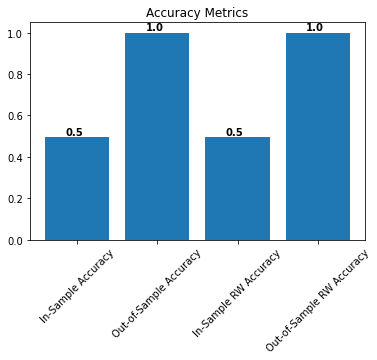

In [25]:
# Compute accuracy metrics for in-sample and out-of-sample data
insample_actual = y_train[1:]
insample_pred = y_train[:-1]
outsample_actual = y_test[1:]
outsample_pred = y_test[:-1]

insample_acc = np.mean(np.equal(np.round(insample_actual), np.round(insample_pred)))
outsample_acc = np.mean(np.equal(np.round(outsample_actual), np.round(outsample_pred)))

insample_rw_acc = np.mean(np.equal(np.round(insample_actual), np.round(y_train[:-1])))
outsample_rw_acc = np.mean(np.equal(np.round(outsample_actual), np.round(y_test[:-1])))

# Create a bar chart to visualize the accuracy metrics
import matplotlib.pyplot as plt

labels = ['In-Sample Accuracy', 'Out-of-Sample Accuracy', 'In-Sample RW Accuracy', 'Out-of-Sample RW Accuracy']
values = [insample_acc, outsample_acc, insample_rw_acc, outsample_rw_acc]
plt.xticks(rotation=45)
for i, v in enumerate(values):
    plt.text(i-0.15, v+0.01, str(round(v, 2)), color='black', fontweight='bold')
plt.bar(labels, values)
plt.title('Accuracy Metrics')
plt.show()





#Don't do 4.) Plot in and out of sample accuracy

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on full dataset

test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * np.cumprod(y_test+1)

train_predict = model.predict(x_train)
train_predictions = (train_predict+1).reshape(1,-1) * np.cumprod(y_train+1)



plt.plot(stock_data[:training_data_len- input_size].index, np.cumprod(y_train+1), label="Training Data")
plt.plot(stock_data[:training_data_len- input_size].index, train_predictions[0], label="Training Predictions")
end_val = np.cumprod(y_train+1)[-1]
test_predict = model.predict(x_test)
test_predictions = (test_predict+1).reshape(1,-1) * (np.cumprod((y_test+1))*end_val)
plt.plot(stock_data[training_data_len+1:].index, np.cumprod((y_test+1))*end_val,label="Test Data")
plt.plot(stock_data[training_data_len+1:].index, test_predictions[0], label="Test Predictions")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

#5.) Write an observation/conclusion about the graphs from Q4 and Q3

In [24]:
#The accuracy of random walk and model is the same, which means the model is not perform better than the randm walk baseline approach. It does not
#provide any additional predictive power. The forecast uses one day head, t-1 but time window is large so it is misleading accuracy. 

# 6.) Create a parameter for number of lags in your input layer. Do a 3-fold CV to test three different time lags. i.e. Tested using 5,10,20 days of previous price data to forecast

In [22]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from keras.wrappers.scikit_learn import KerasRegressor

# Define the Keras model
###Edit here to create your optimizer
def create_model(n_lags=50): #add parameter
    model = Sequential()
    model.add(LSTM(10, input_shape=(50,1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return(model)

# Wrap the Keras model in a scikit-learn compatible estimator
model = KerasRegressor(build_fn=create_model, verbose=0)

# Define the hyperparameters to search over
####EXAMPLE###
n_lags_list = [5, 10, 20]
param_grid = {'batch_size': [10, 20, 100],
              'epochs': [1],
              'n_lags':n_lags_list}

# Perform the grid search over the hyperparameters

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(x_train, y_train)

# Print the results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

<ipython-input-22-97a173a4b0b6>:15: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasRegressor(build_fn=create_model, verbose=0)


Best: -0.535945 using {'batch_size': 10, 'epochs': 1, 'n_lags': 10}
